# Reconstruction of a dark subhalo with wavelets

__authors__: @aymgal

__last update__: 15/07/22

In [1]:
# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm, LogNorm, Normalize, TwoSlopeNorm
plt.rc('image', interpolation='none')

# Basic imports
import numpy as np
from copy import deepcopy
import time
from functools import partial
from pprint import pprint
from getdist import plots as gd_plots
from getdist import MCSamples
from getdist.gaussian_mixtures import GaussianND

# JAX-related
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
import jaxns
from jaxns import NestedSampler
from jaxns.prior_transforms import PriorChain, UniformPrior

# Herculens
from herculens.Coordinates.pixel_grid import PixelGrid
from herculens.Instrument.psf import PSF
from herculens.Instrument.noise import Noise
from herculens.LightModel.light_model import LightModel
from herculens.MassModel.mass_model import MassModel
from herculens.LensImage.lens_image import LensImage
from herculens.Parameters.parameters import Parameters
from herculens.Parameters.covariance import FisherCovariance
from herculens.Inference.loss import Loss
from herculens.Inference.optimization import Optimizer
from herculens.Inference.sampling import Sampler
from herculens.Analysis.plot import Plotter
from herculens.Util import image_util, param_util, plot_util, model_util

# Baseline font soze
FS = 18

# Plotting engine
plotter = Plotter(base_fontsize=FS, flux_vmin=1e-3, flux_vmax=1e0, res_vmax=4)

## 1. Simulate an observation of strong lens

### Define the coordinates grid

In [2]:
npix = 80  # number of pixel on a side
pix_scl = 0.08  # pixel size in arcsec
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2  # position of the (0, 0) with respect to bottom left pixel
transform_pix2angle = pix_scl * np.eye(2)  # transformation matrix pixel <-> angle
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}

# create the PixelGrid class
pixel_grid = PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates
extent = pixel_grid.extent

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")

image size : (80, 80) pixels
pixel size : 0.08 arcsec
x range    : (-3.16, 3.16) arcsec
y range    : (-3.16, 3.16) arcsec


### Point spread function (PSF)

For simplicity we assume here a Gaussian PSF.

In [3]:
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.3}
psf = PSF(**kwargs_psf)

### Noise

In [4]:
# exposure time, used for estimating the shot noise
exp_time = 2000
# standard deviation of the background noise
sigma_bkd = 0.003

kwargs_noise = {'background_rms': sigma_bkd, 'exposure_time': exp_time}
noise = Noise(npix, npix, **kwargs_noise)

### Lens galaxy

We assume a SIE embedded in an external shear

In [5]:
# Lens mass
# including an SIS subhalo
lens_model_input = MassModel(['SIE', 'SHEAR', 'SIS'])

# position of the lens
cx0, cy0 = 0., 0.
# position angle, here in degree
phi = 8.0
# axis ratio, b/a
q = 0.75
# conversion to ellipticities
e1, e2 = param_util.phi_q2_ellipticity(phi * np.pi / 180, q)
# external shear orientation, here in degree
phi_ext = 54.0
# external shear strength
gamma_ext = 0.03 
# conversion to polar coordinates
gamma1, gamma2 = param_util.shear_polar2cartesian(phi_ext * np.pi / 180, gamma_ext)
# position of the subhalo
cx0_sub, cy0_sub = 1., -0.8
kwargs_lens_input = [
    {'theta_E': 1.4, 'e1': e1, 'e2': e2, 'center_x': cx0, 'center_y': cy0},  # SIE
    {'gamma1': gamma1, 'gamma2': gamma2, 'ra_0': 0.0, 'dec_0': 0.0},  # external shear
    {'theta_E': 0.1, 'center_x': cx0_sub, 'center_y': cy0_sub},  # SIS
]
#pprint(kwargs_lens_input)


# Lens light
lens_light_model_input = None
kwargs_lens_light_input = [{}]
#lens_light_model_input = LightModel(['SERSIC_ELLIPSE'])
#kwargs_lens_light_input = [
#    {'amp': 8.0, 'R_sersic': 1.0, 'n_sersic': 3., 'e1': e1, 'e2': e2, 'center_x': cx0, 'center_y': cy0}
#]
#pprint(kwargs_lens_light_input)

### Source galaxy

In [6]:
source_model_input = LightModel(['SERSIC'])
kwargs_source_input = [
    {'amp': 12.0, 'R_sersic': 0.1, 'n_sersic': 1.5, 'center_x': 0.05, 'center_y': 0.1}
]

### Generate the lens image

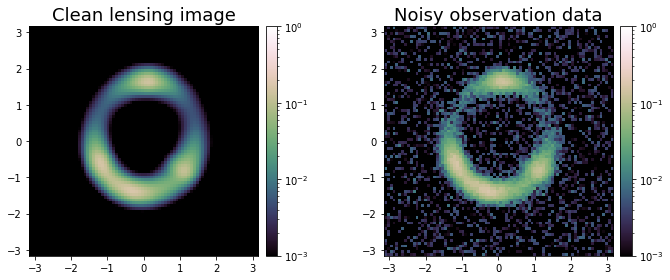

In [7]:
# Generate a lensed image based on source and lens models
kwargs_numerics_simu = {'supersampling_factor': 5}
lens_image_simu = LensImage(pixel_grid, psf, noise_class=noise,
                         lens_mass_model_class=lens_model_input,
                         source_model_class=source_model_input,
                         lens_light_model_class=lens_light_model_input,
                         kwargs_numerics=kwargs_numerics_simu)

kwargs_all_input = dict(kwargs_lens=kwargs_lens_input,
                        kwargs_source=kwargs_source_input,
                        kwargs_lens_light=kwargs_lens_light_input)
image = lens_image_simu.model(**kwargs_all_input)

data = lens_image_simu.simulation(**kwargs_all_input, noise_seed=42)

# visualize simulated products
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
img1 = ax1.imshow(image, origin='lower', extent=extent, norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(img1)
ax1.set_title("Clean lensing image", fontsize=FS)
img2 = ax2.imshow(data, origin='lower', extent=extent, norm=plotter.norm_flux, cmap=plotter.cmap_flux)
ax2.set_title("Noisy observation data", fontsize=FS)
plot_util.nice_colorbar(img2)
fig.tight_layout()
plt.show()

In [8]:
# inform the plotter of the data and, if any, the true source 
plotter.set_data(data)

source_input = lens_image_simu.source_surface_brightness(kwargs_source_input, de_lensed=True, unconvolved=True)
plotter.set_ref_source(source_input)

## 2. Lens modeling

### 2.1. Smooth model, no subhalo included

For this example we assume the same models as in the simulated data.

In [9]:
lens_model_smooth = MassModel(['SIE', 'SHEAR'])

In [10]:
kwargs_numerics_smooth = {'supersampling_factor': 1}  # increase for better results, here it's 1 for runtime
lens_image_smooth = LensImage(deepcopy(pixel_grid), deepcopy(psf), noise_class=deepcopy(noise),
                         lens_mass_model_class=lens_model_smooth,
                         source_model_class=deepcopy(source_model_input),
                         lens_light_model_class=deepcopy(lens_light_model_input),
                         kwargs_numerics=kwargs_numerics_smooth)

### Decide on the parameters to optimize

We set our initial values for the parameters we want to optimise, and set fixed parameters (here we fix source parameters to the truth). We also set possible priors among `'uniform'` and `'gaussian'` for a subset of parameters.

We simulate a initial guess of parameters by slightly perturbing some of the parameters.

In this example we assume the lens light is perfectly known.

In [11]:
kwargs_init = {
    'kwargs_lens': [
        {'theta_E': 1.38, 'e1': e1+0.01, 'e2': e2-0.01, 'center_x': 1e-3, 'center_y': 1e-3}, 
        {'gamma1': gamma1-0.01, 'gamma2': gamma2+0.01}
    ],
    'kwargs_lens_light': [{}],
    'kwargs_source': [
        {'amp': 1e1, 'R_sersic': 0.04, 'n_sersic': 1.7, 'center_x': 0.04, 'center_y': 0.12}
    ],
}
kwargs_fixed = {
    # we fix origin of the external shear profile as we don't want to optimize it
    'kwargs_lens': [
        {}, 
        {'ra_0': 0., 'dec_0': 0.}
    ],
    'kwargs_lens_light': kwargs_lens_light_input,
    'kwargs_source': [{}],
}
if lens_light_model_input is not None:
    kwargs_joint = {
        # joint centroid for lens mass and light distributions
        'lens_with_lens_light': [
            [
                (0, 0), [('center_x', 'center_x'), ('center_y', 'center_y')]
            ]
        ]
    }
else:
    kwargs_joint = None
parameters_smooth = Parameters(lens_image_smooth, kwargs_init, kwargs_fixed, kwargs_joint=kwargs_joint)
print("Number of fitted parameters for smooth model:", parameters_smooth.num_parameters)
print("Parameter names:", parameters_smooth.names)

#print("prior types:", parameters.prior_types)
#print("lower/upper bounds (for uniform priors):", *parameters.bounds)

# save the array of input parameters for latter use
params_input_smooth = parameters_smooth.kwargs2args(kwargs_all_input)

Number of fitted parameters for smooth model: 12
Parameter names: ['theta_E-lens-0', 'e1-lens-0', 'e2-lens-0', 'center_x-lens-0', 'center_y-lens-0', 'gamma1-lens-1', 'gamma2-lens-1', 'amp-source-0', 'R_sersic-source-0', 'n_sersic-source-0', 'center_x-source-0', 'center_y-source-0']


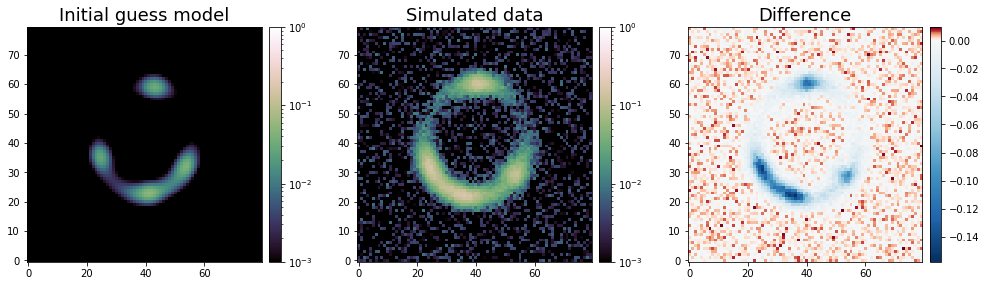

In [12]:
# visualize initial guess
initial_model = lens_image_smooth.model(**parameters_smooth.initial_values(as_kwargs=True))

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
ax = axes[0]
ax.set_title("Initial guess model", fontsize=FS)
im = ax.imshow(initial_model, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(im)
ax = axes[1]
ax.set_title("Simulated data", fontsize=FS)
im = ax.imshow(data, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(im)
ax = axes[2]
ax.set_title("Difference", fontsize=FS)
im = ax.imshow(initial_model - data, origin='lower', norm=TwoSlopeNorm(0), cmap=plotter.cmap_res)
plot_util.nice_colorbar(im)
fig.tight_layout()
plt.show()

### Define the loss function

By default, it follows from the assumption of Gaussian errors so it is equal to half the generalized $\chi^2$ of the data given the model.

You can also choose which prior types to include (`None`, `'gaussian'`, `'uniform'` or both).

In [13]:
loss_smooth = Loss(data, lens_image_smooth, parameters_smooth, likelihood_type='chi2')

Just for fun, let's check the gradient and hessian matrix of the loss function, evaluated at the input values.

_Remember than the first time these methods are called, the runtime is longer as it has not been JIT-compiled yet!_

In [14]:
loss_smooth.gradient(params_input_smooth).block_until_ready()

DeviceArray([  -8379.92106956,  -38883.96170556,   46026.9120287 ,
             -126007.69943639,  120589.62460544,   80683.43115119,
              -74774.72609322,    2591.09716103,  361044.34801544,
               11527.47677166,  171096.31882899, -116284.06463649],            dtype=float64)

### Set the optimizer to minimize the loss function

In [15]:
optimizer_smooth = Optimizer(loss_smooth, parameters_smooth)

Below we use the method from `scipy.optimize.mininize`. In `Herculens`, the supported methods are:
- `'Nelder-Mead'`: uses no analytical gradient;
- `'BFGS'`: uses gradient;
- `'Newton-CG'`/`'trust-krylov'`/`'trust-constr'`: uses gradient and hessian-vector product. In addition, `'trust-constr'` uses bounds from uniform prior consistently within the optimization;
- `'trust-exact'` (uses gradient and hessian).

Setting `use_exact_hessian_if_allowed=True` forces methods that use the hessian-vector product to use the full hessian instead.

In [16]:
best_fit, logL, extra_fields, runtime \
    = optimizer_smooth.minimize(method='BFGS', restart_from_init=True,
                         use_exact_hessian_if_allowed=False,
                         return_param_history=True)
print(f"Runtime: {runtime}")

# save a copy of optimized parameters
kwargs_bestfit_smooth = deepcopy(parameters_smooth.best_fit_values(as_kwargs=True))

minimize.BFGS: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]

Runtime: 1.787513017654419


In [17]:
extra_fields.keys()

dict_keys(['result_class', 'jac', 'hess', 'hess_inv', 'best_fit_index', 'loss_history', 'loss_history_list', 'param_history', 'param_history_list'])

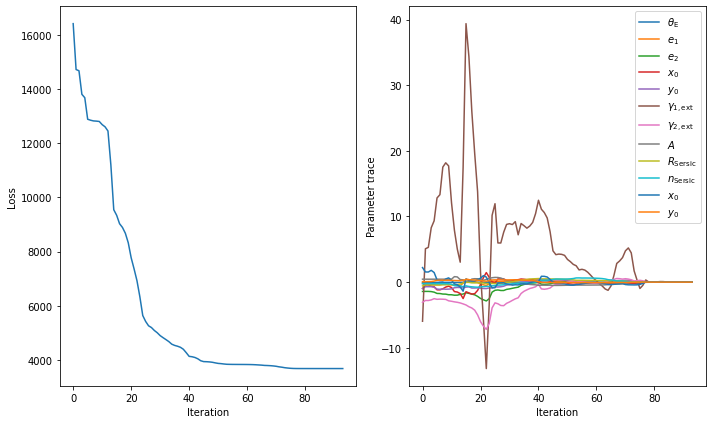

In [18]:
plot_util.plot_minimize_history(parameters_smooth, extra_fields)

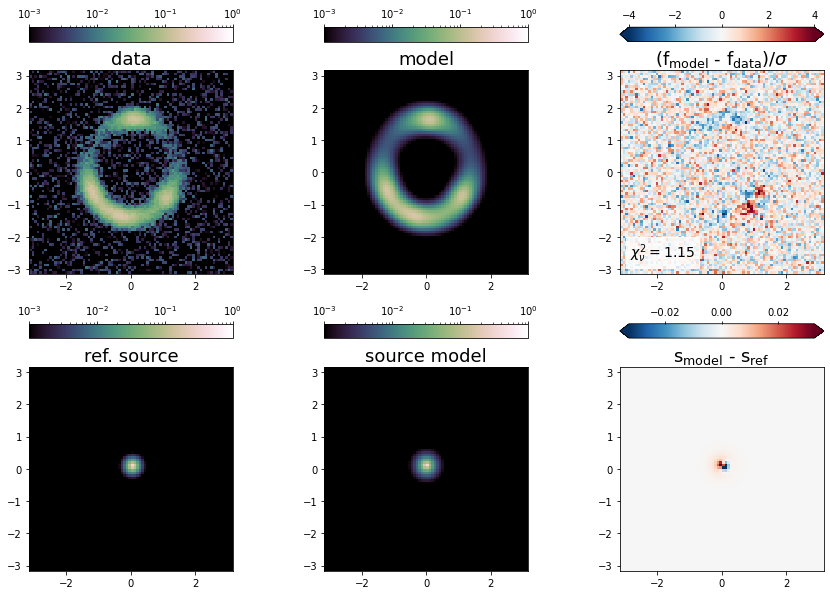

In [19]:
fig = plotter.model_summary(lens_image_smooth, kwargs_bestfit_smooth, show_source=True)

In [20]:
# print resulting parameters
print("BEST-FIT VALUES:")
pprint(kwargs_bestfit_smooth)

print("="*60)

# compare to input values
print("INPUT VALUES:")
pprint(kwargs_all_input)

BEST-FIT VALUES:
{'kwargs_lens': [{'center_x': array(0.02032308),
                  'center_y': array(-0.06580285),
                  'e1': array(0.18647567),
                  'e2': array(-0.07141477),
                  'theta_E': array(1.47428739)},
                 {'dec_0': 0.0,
                  'gamma1': array(0.00247326),
                  'gamma2': array(-0.01791444),
                  'ra_0': 0.0}],
 'kwargs_lens_light': [],
 'kwargs_source': [{'R_sersic': array(0.13217191),
                    'amp': array(6.92005066),
                    'center_x': array(0.01270096),
                    'center_y': array(0.11358086),
                    'n_sersic': array(2.21920699)}]}
INPUT VALUES:
{'kwargs_lens': [{'center_x': 0.0,
                  'center_y': 0.0,
                  'e1': DeviceArray(0.1373231, dtype=float64),
                  'e2': DeviceArray(0.03937677, dtype=float64),
                  'theta_E': 1.4},
                 {'dec_0': 0.0,
                  'gamma1': Devi

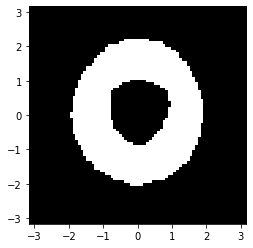

In [21]:
arc_mask, _ = model_util.mask_from_lensed_source(lens_image_smooth, parameters=parameters_smooth, 
                                                 threshold=sigma_bkd, smoothing=0)
plt.imshow(arc_mask, origin='lower', extent=extent, cmap='gray')
plt.show()

### 2.2. Add pixelated deviations to the smooth mass model

In [22]:
kwargs_pixelated_lens = {'pixel_scale_factor': 3, 'conserve_extent': True}
lens_model_full = MassModel(['SIE', 'SHEAR', 'PIXELATED'],
                            kwargs_pixelated=kwargs_pixelated_lens)

In [23]:
kwargs_numerics_full = {'supersampling_factor': 1}  # increase for better results, here it's 1 for runtime
lens_image_full = LensImage(deepcopy(pixel_grid), deepcopy(psf), noise_class=deepcopy(noise),
                         lens_mass_model_class=lens_model_full,
                         source_model_class=deepcopy(source_model_input),
                         lens_light_model_class=deepcopy(lens_light_model_input),
                         kwargs_numerics=kwargs_numerics_full)

In [24]:
# inform the plotter about the true subhalo potential (on the pixelated grid)
x_grid_lens, y_grid_lens = lens_image_full.Grid.model_pixel_coordinates('lens')
subhalo_input_fitgrid = lens_image_simu.MassModel.potential(x_grid_lens, y_grid_lens, kwargs_lens_input, k=-1)
plotter.set_ref_pixelated_potential(subhalo_input_fitgrid)

In [25]:
# start from previous fit
kwargs_init = deepcopy(kwargs_bestfit_smooth)
# choose initial value for pixelated potential
kwargs_init['kwargs_lens'].append({'pixels': 1e-8})

kwargs_fixed = {
    # we fix origin of the external shear profile as we don't want to optimize it
    'kwargs_lens': [{}, {'ra_0': 0., 'dec_0': 0.}, {}],
    'kwargs_lens_light': kwargs_lens_light_input,
    'kwargs_source': [{}],
}
if lens_light_model_input is not None:
    kwargs_joint = {
        # joint centroid for lens mass and light distributions
        'lens_with_lens_light': [
            [
                (0, 0), [('center_x', 'center_x'), ('center_y', 'center_y')]
            ]
        ]
    }
else:
    kwargs_joint = None
parameters_full = Parameters(lens_image_full, kwargs_init, kwargs_fixed, kwargs_joint=kwargs_joint)
print("Number of fitted parameters for full model:", parameters_full.num_parameters)
#print("Parameter names:", parameters_full.names)

Number of fitted parameters for full model: 741


#### Compute regularization weights

In [26]:
# This might take a few seconds
regul_weights_st, regul_weights_bl \
    = model_util.data_noise_to_wavelet_potential(data, lens_image_full, 
                                                 parameters_full.initial_values(as_kwargs=True),
                                                 likelihood_type='chi2',
                                                 wavelet_type_list=['starlet', 'battle-lemarie-3'], 
                                                 num_samples=10000, seed=8)

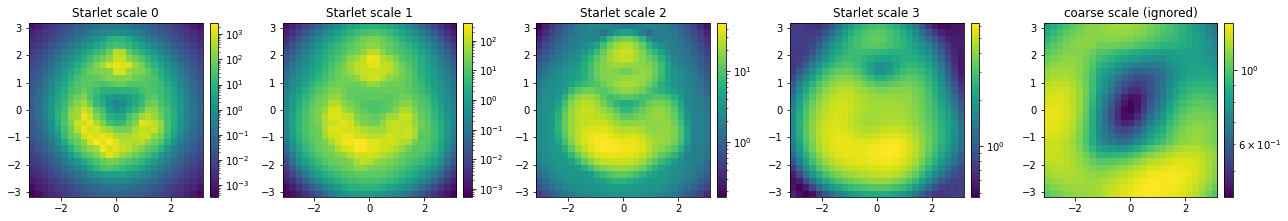

In [27]:
# visualize the weights
weights_to_plot = regul_weights_st  # pot_noise_bl

fig, axes = plt.subplots(1, weights_to_plot.shape[0], figsize=(18, 4))
for k in range(weights_to_plot.shape[0]):
    ax = axes[k]
    if k == weights_to_plot.shape[0]-1:
        ax.set_title(f"coarse scale (ignored)")
    else:
        ax.set_title(f"Starlet scale {k}")
    im = ax.imshow(weights_to_plot[k], origin='lower', extent=extent,
                   #cmap='Spectral_r', norm=TwoSlopeNorm(0)
                   cmap='viridis', norm=LogNorm()
                  )
    plot_util.nice_colorbar(im)
fig.tight_layout()
plt.show()

#### Define the loss function, including specific regularization terms

In [28]:
# Create loss
loss_full_1 = Loss(data, lens_image_full, parameters_full, 
                 likelihood_type='chi2',
                   likelihood_mask=arc_mask,
                 regularization_terms=[
                     'l1_starlet_potential', 
                     'l1_battle_potential'
                 ], 
                 regularization_strengths=[
                     # over-regularize for a first optimization run
                     (5, 4), 
                     3
                 ],
                 regularization_weights=[
                     regul_weights_st, 
                     regul_weights_bl
                 ],
                 prior_terms=None)

print("Loss at initial values:", loss_full_1(parameters_full.initial_values()))
_ = loss_full_1.gradient(parameters_full.initial_values())  # just to pre-compile the gradient

Loss at initial values: 1206.1472212620947


optax.adabelief: 100%|██████████| 800/800 [00:17<00:00, 44.97it/s]


Runtime: 17.791563987731934
Loss at best-fit: 1125.608221298526


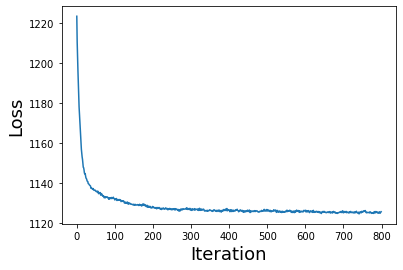

In [29]:
optimizer_full_1 = Optimizer(loss_full_1, parameters_full)

# optimizer settings
max_iterations = 800
init_learning_rate = 1e-4

best_fit, logL, extra_fields, runtime \
    = optimizer_full_1.optax(max_iterations=max_iterations, 
                             init_learning_rate=init_learning_rate,
                             restart_from_init=True)
print(f"Runtime: {runtime}")
print("Loss at best-fit:", loss_full_1(best_fit))

# save results as kwargs
kwargs_bestfit_full_1 = parameters_full.best_fit_values(as_kwargs=True)

# loss history
fig, ax = plt.subplots(1, 1)
ax.plot(range(len(extra_fields['loss_history'])), extra_fields['loss_history'])
ax.set_ylabel("Loss", fontsize=FS)
ax.set_xlabel("Iteration", fontsize=FS)
plt.show()

_Note: the reduced $\chi^2$ of the residuals is higher because of the lower number of pixels within the mask._

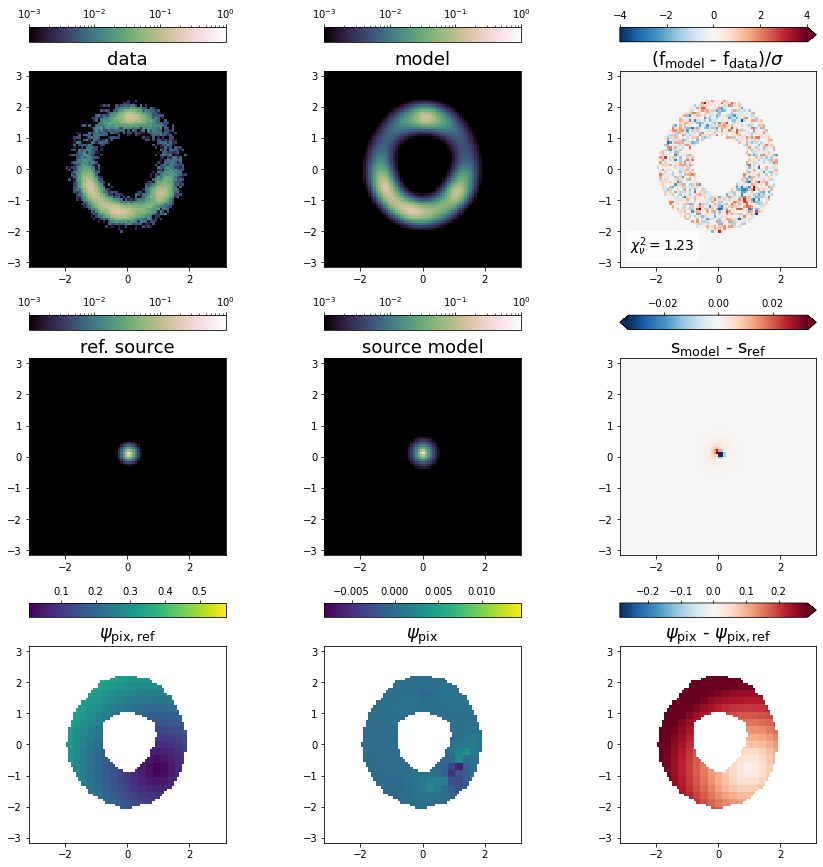

In [30]:
fig = plotter.model_summary(lens_image_full, kwargs_bestfit_full_1, 
                            likelihood_mask=arc_mask,
                            show_source=True, show_lens_potential=True)

#### We can further decrease regularization strengths to improve the model

In [31]:
# Create loss
loss_full_2 = Loss(data, lens_image_full, parameters_full, 
                 likelihood_type='chi2',
                   likelihood_mask=arc_mask,
                 regularization_terms=[
                     'l1_starlet_potential', 
                     'l1_battle_potential'
                 ], 
                 regularization_strengths=[
                     # over-regularize for a first optimization run
                     3, 
                     3
                 ],
                 regularization_weights=[
                     regul_weights_st, 
                     regul_weights_bl
                 ],
                 prior_terms=None)

print("Loss at initial values:", loss_full_2(parameters_full.initial_values()))
_ = loss_full_2.gradient(parameters_full.initial_values())  # just to pre-compile the gradient

Loss at initial values: 1206.1472212620947


optax.adabelief: 100%|██████████| 800/800 [00:10<00:00, 75.49it/s]


Runtime: 10.5991690158844
Loss at best-fit: 1076.3235518512042


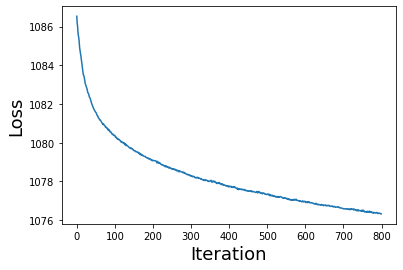

In [32]:
optimizer_full_2 = Optimizer(loss_full_2, parameters_full)

# optimizer settings
max_iterations = 800
init_learning_rate = 1e-5

best_fit, logL, extra_fields, runtime \
    = optimizer_full_2.optax(max_iterations=max_iterations, 
                             init_learning_rate=init_learning_rate,
                             restart_from_init=False)
print(f"Runtime: {runtime}")
print("Loss at best-fit:", loss_full_2(best_fit))

# save results as kwargs
kwargs_bestfit_full_2 = parameters_full.best_fit_values(as_kwargs=True)

# loss history
fig, ax = plt.subplots(1, 1)
ax.plot(range(len(extra_fields['loss_history'])), extra_fields['loss_history'])
ax.set_ylabel("Loss", fontsize=FS)
ax.set_xlabel("Iteration", fontsize=FS)
plt.show()

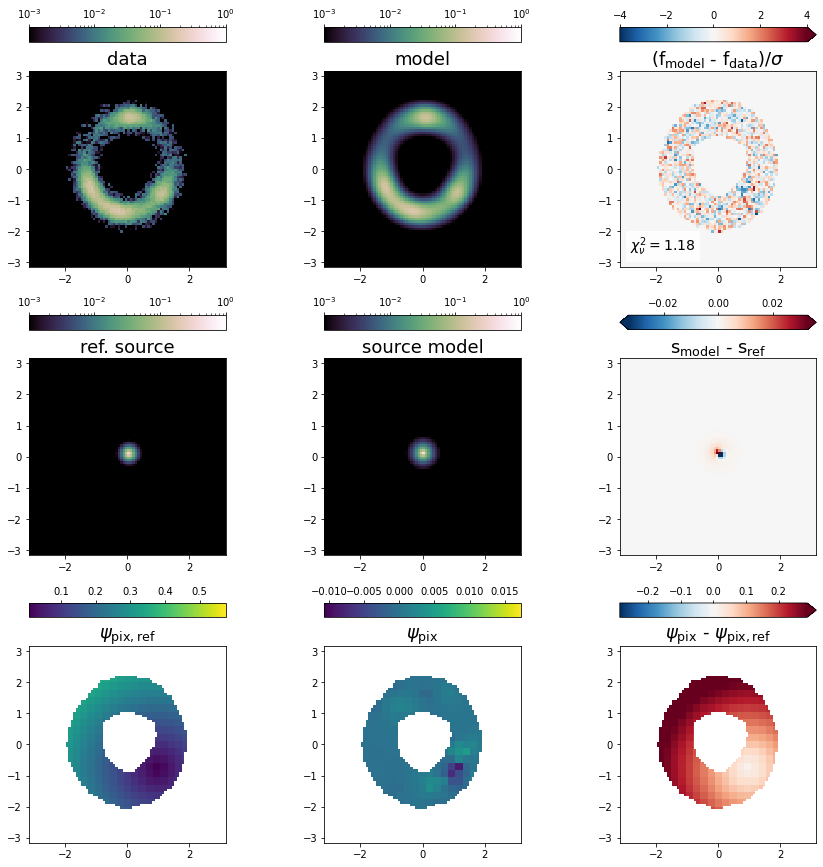

In [35]:
fig = plotter.model_summary(lens_image_full, kwargs_bestfit_full_2, 
                            likelihood_mask=arc_mask,
                            show_source=True, show_lens_potential=True, show_lens_others=False)

### Next step(s): characterize the subhalo

Now that we have a detection of a massive structure in the pixelated potential model, we need to better measure the uncertainty on its position. Additionally, if the data is sufficiently constraining (SNR, effective resolution), it may be possible to estimate its mass and radial mass profile.

One way to achieve these goals is to replace the pixelated model by an anylytical profile, and optimize further model parameters. The Fisher information or Hamiltonian Monte Carlo sampling can then be used to estimate uncertainties and covariances.

`Herculens` allows to do that: this is left as an exercise to the modellers ;)